In [1]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder 
from mlxtend.frequent_patterns import fpgrowth
from sklearn.preprocessing import LabelBinarizer

# **1. Importing the dataset**

In [2]:
products = pd.read_csv(r'C:\Users\Aparna Akula\Documents\
                        Data Mining\Project\products.csv')
display(products.head())
print(products.shape)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


(49688, 4)


In [3]:
aisles = pd.read_csv(r'C:\Users\Aparna Akula\Documents\
                        Data Mining\Project\aisles.csv')
display(aisles.head())
print(aisles.shape)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


(134, 2)


In [4]:
departments = pd.read_csv(r'C:\Users\Aparna Akula\Documents\
                        Data Mining\Project\departments.csv')
display(departments.head())
print(departments.shape)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


(21, 2)


In [5]:
order_products__train = pd.read_csv(r'C:\Users\Aparna Akula\Documents\
                        Data Mining\Project\order_products__train.csv')
display(order_products__train.head())
print(order_products__train.shape)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


(1384617, 4)


In [6]:
order_products__prior = pd.read_csv(r'C:\Users\Aparna Akula\Documents\
                        Data Mining\Project\order_products__prior.csv')
display(order_products__prior.head())
print(order_products__prior.shape)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


(32434489, 4)


In [7]:
orders = pd.read_csv(r'C:\Users\Aparna Akula\Documents\
                        Data Mining\Project\orders.csv')
display(orders.head())
print(orders.shape)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


(3421083, 7)


In [8]:
# joining orders and prior
train_and_prior = pd.concat([order_products__prior, 
            order_products__train],ignore_index=True)
train_and_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
33819101,3421063,14233,3,1
33819102,3421063,35548,4,1
33819103,3421070,35951,1,1
33819104,3421070,16953,2,1


## 2. Combining datasets

In [9]:
df1 = pd.merge(aisles, products, how='inner', on='aisle_id')
df2 = pd.merge(df1, departments, how='inner', on='department_id')
df3 = pd.merge(train_and_prior, df2, how='inner', on='product_id')
df4 = pd.merge(orders, df3, how='inner', on='order_id')

In [10]:
#df = df4.drop(['aisle_id','department_id','eval_set','order_number','product_id'],axis=1)
df = df4.drop(['aisle_id','department_id','product_id'],axis=1)
display(df.head())
print('The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,aisle,product_name,department
0,2539329,1,prior,1,2,8,NaN,1,0,soft drinks,Soda,beverages
1,2539329,1,prior,1,2,8,NaN,2,0,soy lactosefree,Organic Unsweetened Vanilla Almond Milk,dairy eggs
2,2539329,1,prior,1,2,8,NaN,4,0,popcorn jerky,Aged White Cheddar Popcorn,snacks
3,2539329,1,prior,1,2,8,NaN,3,0,popcorn jerky,Original Beef Jerky,snacks
4,2539329,1,prior,1,2,8,NaN,5,0,paper goods,XL Pick-A-Size Paper Towel Rolls,household


The Dataset consists of 12 features & 33819106 samples.


## Exploratory Data Analysis

In [11]:
df.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
add_to_cart_order           int64
reordered                   int64
aisle                      object
product_name               object
department                 object
dtype: object

In [12]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 12)


In [13]:
df.count()

order_id                  33819106
user_id                   33819106
eval_set                  33819106
order_number              33819106
order_dow                 33819106
order_hour_of_day         33819106
days_since_prior_order    31741038
add_to_cart_order         33819106
reordered                 33819106
aisle                     33819106
product_name              33819106
department                33819106
dtype: int64

In [14]:
print(df.isnull().sum())

order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
add_to_cart_order               0
reordered                       0
aisle                           0
product_name                    0
department                      0
dtype: int64


In [15]:
df_null = df.dropna() 
df_null.count()

order_id                  31741038
user_id                   31741038
eval_set                  31741038
order_number              31741038
order_dow                 31741038
order_hour_of_day         31741038
days_since_prior_order    31741038
add_to_cart_order         31741038
reordered                 31741038
aisle                     31741038
product_name              31741038
department                31741038
dtype: int64

*Ref: https://towardsdatascience.com/exploratory-data-analysis-in-python-c9a77dfa39ce*

In [16]:
df.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.174104e+07,3.381911e+07,3.381911e+07
mean,1.710566e+06,1.029444e+05,1.713998e+01,2.737285e+00,1.343123e+01,1.136415e+01,8.367738e+00,5.900617e-01
std,9.874008e+05,5.946733e+04,1.749829e+01,2.093296e+00,4.246149e+00,8.940500e+00,7.139540e+00,4.918220e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,8.554130e+05,5.143500e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,3.000000e+00,0.000000e+00
50%,1.710660e+06,1.026260e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,6.000000e+00,1.000000e+00
75%,2.565587e+06,1.544120e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,1.100000e+01,1.000000e+00
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,1.450000e+02,1.000000e+00


In [17]:
a = len(df['order_id'].unique())
b = len(df['user_id'].unique())
print(a)
print(b)

3346083
206209


In [18]:
a = df['aisle'].unique()
len(a)

134

In [19]:
a = df['product_name'].unique()
len(a)

49685

In [20]:
a = df['department'].unique()
len(a)
print(a)

['beverages' 'dairy eggs' 'snacks' 'household' 'produce' 'breakfast'
 'pantry' 'deli' 'frozen' 'personal care' 'meat seafood' 'international'
 'bakery' 'canned goods' 'dry goods pasta' 'alcohol' 'pets' 'babies'
 'other' 'missing' 'bulk']


## Visuals

In [21]:
from matplotlib.pyplot import figure

figure(figsize=(10, 7))

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

C:\Users\Aparna Akula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


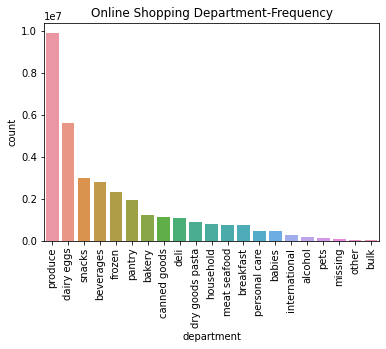

In [22]:
sns.countplot(df.department, order=df.department.value_counts().index)
plt.title('Online Shopping Department-Frequency')
plt.xticks(rotation=90)
plt.show()

C:\Users\Aparna Akula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


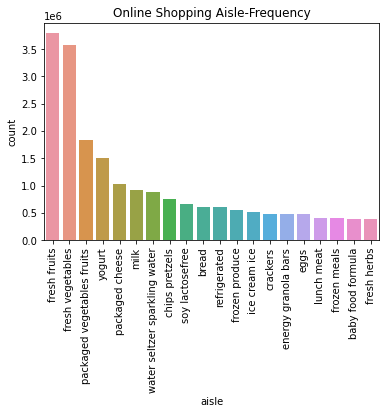

In [23]:
sns.countplot(df.aisle, order=df.aisle.value_counts().index[:20])
plt.title('Online Shopping Aisle-Frequency')
plt.xticks(rotation=90)
plt.show()

C:\Users\Aparna Akula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


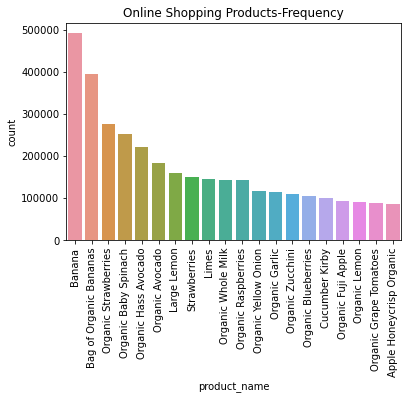

In [24]:
sns.countplot(df.product_name, order=df.product_name.value_counts().index[:20])
plt.title('Online Shopping Products-Frequency')
plt.xticks(rotation=90)
plt.show()

C:\Users\Aparna Akula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


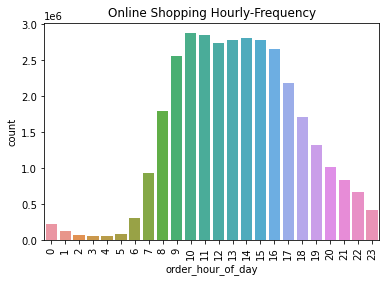

In [25]:
sns.countplot(df.order_hour_of_day)#, order=df.aisle.value_counts().index[:20])
plt.title('Online Shopping Hourly-Frequency')
plt.xticks(rotation=90)
plt.show()

## 1.Apriori

In [26]:
#sample
sample1 = df[df['order_id']<30000]

In [27]:
df_item = sample1[['order_id','product_name']].copy()
df_item.rename(columns={'order_id':'order','product_name':'items'},inplace=True)
df_item['temp']=1

In [28]:
df_2 = df_item.groupby(['order','items'])['temp'].sum().unstack().fillna(0)

In [29]:
def myencoder(i):
    if i <= 0:
        return 0
    elif i>=1:
        return 1

In [30]:
from datetime import datetime
start = datetime.now()

df_3 = df_2.applymap(myencoder)

from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(df_3, 
                            min_support = 0.01, 
                            max_len = 2, 
                            use_colnames = True)
print(frequent_itemsets.head())

frequent_itemsets.shape

rules_1 = association_rules(frequent_itemsets, 
                            metric="confidence", min_threshold=0)
print(rules_1)

end = datetime.now()
print(end - start)

    support                    itemsets
0  0.011755    (100% Raw Coconut Water)
1  0.019114    (100% Whole Wheat Bread)
2  0.012504       (2% Reduced Fat Milk)
3  0.026099  (Apple Honeycrisp Organic)
4  0.020102                 (Asparagus)
                 antecedents               consequents  antecedent support  \
0   (Bag of Organic Bananas)    (Organic Baby Spinach)            0.119557   
1     (Organic Baby Spinach)  (Bag of Organic Bananas)            0.074787   
2   (Bag of Organic Bananas)    (Organic Hass Avocado)            0.119557   
3     (Organic Hass Avocado)  (Bag of Organic Bananas)            0.066474   
4   (Bag of Organic Bananas)     (Organic Raspberries)            0.119557   
5      (Organic Raspberries)  (Bag of Organic Bananas)            0.043237   
6     (Organic Strawberries)  (Bag of Organic Bananas)            0.080511   
7   (Bag of Organic Bananas)    (Organic Strawberries)            0.119557   
8                   (Banana)          (Cucumber Kirby)    

## 2.FP_Growth

In [32]:
from datetime import datetime
start = datetime.now()

df_3 = df_2.applymap(myencoder)

frequent_itemsets_fp=fpgrowth(df_3, min_support=0.01,use_colnames=True)
rules_fp = association_rules(frequent_itemsets_fp, 
            metric="confidence", min_threshold=0)

rules_fp

end = datetime.now()
print(end - start)

0:13:37.774186


In [33]:
print(rules_fp)

   antecedents consequents  antecedent support  consequent support   support  \
0      (14907)      (1646)            0.066474            0.119557  0.019012   
1       (1646)     (14907)            0.119557            0.066474  0.019012   
2       (1752)     (14907)            0.148109            0.066474  0.010426   
3      (14907)      (1752)            0.066474            0.148109  0.010426   
4      (13930)     (14907)            0.074787            0.066474  0.010051   
5      (14907)     (13930)            0.066474            0.074787  0.010051   
6      (14907)     (15980)            0.066474            0.080511  0.012675   
7      (15980)     (14907)            0.080511            0.066474  0.012675   
8       (1752)      (5655)            0.148109            0.030664  0.010358   
9       (5655)      (1752)            0.030664            0.148109  0.010358   
10      (1752)     (13930)            0.148109            0.074787  0.016491   
11     (13930)      (1752)            0.

## 3.ECLAT

In [34]:
sample2 = df[df['order_id']<5000]

In [35]:
e_df = sample2.groupby(['order_id'])['product_name'].apply(', '.join).reset_index()
e_df.head()

transactions = e_df['product_name'].apply(lambda t: t.split(','))
transactions = list(transactions)
len(transactions)

4910

In [36]:
transactions

[['Bag of Organic Bananas',
  ' Organic Hass Avocado',
  ' Cucumber Kirby',
  ' Organic Whole String Cheese',
  ' Organic Celery Hearts',
  ' Organic 4% Milk Fat Whole Milk Cottage Cheese',
  ' Lightly Smoked Sardines in Olive Oil',
  ' Bulgarian Yogurt'],
 ['Organic Egg Whites',
  ' Michigan Organic Kale',
  ' Garlic Powder',
  ' Coconut Butter',
  ' Natural Sweetener',
  ' Carrots',
  ' Original Unflavored Gelatine Mix',
  ' All Natural No Stir Creamy Almond Butter',
  ' Classic Blend Cole Slaw'],
 ['Total 2% with Strawberry Lowfat Greek Strained Yogurt',
  ' Unsweetened Almondmilk',
  ' Lemons',
  ' Organic Baby Spinach',
  ' Unsweetened Chocolate Almond Breeze Almond Milk',
  ' Organic Ginger Root',
  ' Air Chilled Organic Boneless Skinless Chicken Breasts',
  ' Organic Ezekiel 49 Bread Cinnamon Raisin'],
 ['Plain Pre-Sliced Bagels',
  ' Honey/Lemon Cough Drops',
  ' Chewy 25% Low Sugar Chocolate Chip Granola',
  ' Oats & Chocolate Chewy Bars',
  " Kellogg's Nutri-Grain Apple Cinna

In [37]:
!pip install pyECLAT

In [38]:
list2 = pd.DataFrame(transactions)

In [39]:
list2.head(3)

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,Bag of Organic Bananas,Organic Hass Avocado,Cucumber Kirby,Organic Whole String Cheese,Organic Celery Hearts,Organic 4% Milk Fat Whole Milk Cottage Cheese,Lightly Smoked Sardines in Olive Oil,Bulgarian Yogurt,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Organic Egg Whites,Michigan Organic Kale,Garlic Powder,Coconut Butter,Natural Sweetener,Carrots,Original Unflavored Gelatine Mix,All Natural No Stir Creamy Almond Butter,Classic Blend Cole Slaw,None,...,None,None,None,None,None,None,None,None,None,None
2,Total 2% with Strawberry Lowfat Greek Strained...,Unsweetened Almondmilk,Lemons,Organic Baby Spinach,Unsweetened Chocolate Almond Breeze Almond Milk,Organic Ginger Root,Air Chilled Organic Boneless Skinless Chicken...,Organic Ezekiel 49 Bread Cinnamon Raisin,None,None,...,None,None,None,None,None,None,None,None,None,None


In [40]:
from pyECLAT import ECLAT
eclat = ECLAT(data=list2)

In [ ]:
from datetime import datetime

start = datetime.now()


min_support = 1/100

# start from transactions containing at least 2 items
min_combination = 2

# up to maximum items per transaction
max_combination = 2

rule_indices, rule_supports = eclat.fit(min_support=min_support,
                                min_combination=min_combination,
                                max_combination=max_combination,
                                separator=' & ',verbose=True)

end = datetime.now()
print(end - start)

In [ ]:
result = pd.DataFrame(rule_supports.items(),columns=['Item', 'Support'])
result.sort_values(by=['Support'], ascending=False)

## 4.FAST APRIORI

In [41]:
sample3 = df[df['order_id']<50000]

df_item2 = sample3[['order_id','product_name']].copy()
df_item2.rename(columns={'order_id':'order','product_name':'items'},inplace=True)
df_item2['temp']=1

df_fa = df_item2.groupby(['order','items'])['temp'].sum().unstack().fillna(0)

In [43]:
def fast_apriori(df_FA):
  frequent = apriori(df_FA,min_support=0.01,
                     use_colnames=True)
  rules_apriori = association_rules(frequent,metric='support',
                    support_only=True,min_threshold=0.004)
  output = rules_apriori[['antecedents','consequents','support']]
  output['antecedents'].duplicated().sum()
  cols = ['antecedents','consequents']
  output[cols] = output[cols].applymap(lambda x: tuple(x))
  output = output.explode('antecedents').reset_index(drop=True).
                    explode('consequents').reset_index(drop=True)
  output.sort_values('support',ascending=False)
  print(output)

In [44]:
from datetime import datetime
start = datetime.now()

fast_apriori(df_fa)

end = datetime.now()
print(end - start)

               antecedents             consequents   support
0   Bag of Organic Bananas    Organic Baby Spinach  0.016185
1     Organic Baby Spinach  Bag of Organic Bananas  0.016185
2   Bag of Organic Bananas    Organic Hass Avocado  0.019418
3     Organic Hass Avocado  Bag of Organic Bananas  0.019418
4   Bag of Organic Bananas     Organic Raspberries  0.013423
5      Organic Raspberries  Bag of Organic Bananas  0.013423
6     Organic Strawberries  Bag of Organic Bananas  0.019030
7   Bag of Organic Bananas    Organic Strawberries  0.019030
8                   Banana             Large Lemon  0.012891
9              Large Lemon                  Banana  0.012891
10         Organic Avocado                  Banana  0.016738
11                  Banana         Organic Avocado  0.016738
12                  Banana    Organic Baby Spinach  0.016615
13    Organic Baby Spinach                  Banana  0.016615
14                  Banana      Organic Fuji Apple  0.010088
15      Organic Fuji App

C:\Users\Aparna Akula\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## 5.Super Fast Apriori

In [60]:
orders1 = order_products__prior.set_index('order_id')['product_id'].rename('item_id')
display(orders1.head(10))
type(orders1)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

In [61]:
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))
print('dimensions: {0};   size: {1};   unique_orders: {2};   unique_items: {3}'
      .format(orders1.shape, size(orders), len(orders1.index.unique()), len(orders1.value_counts())))

dimensions: (32434489,);   size: 376.24 MB;   unique_orders: 3214874;   unique_items: 49677


In [62]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]  

In [63]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))
    
    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100
    
    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))

    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))

    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100

    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)

    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))

    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))

    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [64]:
orders1 = orders1[0:50000,]

In [65]:
#dataset with 50,000 records
from datetime import datetime
start = datetime.now()

rules = association_rules(orders1, 0.01) 

end = datetime.now()
print(end - start)

Starting order_item:                  50000
Items with support >= 0.01:           11616
Remaining order_item:                 50000
Remaining orders with 2+ items:        4752
Remaining order_item:                 49774
Item pairs:                          320078
Item pairs with support >= 0.01:     320078

0:00:02.965432


In [ ]:
from datetime import datetime
start = datetime.now()

rules = association_rules(df_3, 0.01) 

end = datetime.now()
print(end - start)

In [66]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv(r'C:\Users\Aparna Akula\Documents\Data Mining\Project\products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Unstopables Downy Unstopables Fresh In-Wash Sc...,"Pistachios, Premium Blend, Pomegranate, with A...",1,0.021044,1,0.021044,1,0.021044,1.000000,1.000000,47.520000
245100,Organic Seedless Raisins,Pure Wildflower Raw Honey,1,0.021044,1,0.021044,1,0.021044,1.000000,1.000000,47.520000
245231,Quince,Lightly Toasted Almond Butter Crunchy,1,0.021044,1,0.021044,1,0.021044,1.000000,1.000000,47.520000
245230,Dragon Fruit,Lightly Toasted Almond Butter Crunchy,1,0.021044,1,0.021044,1,0.021044,1.000000,1.000000,47.520000
245220,Dragon Fruit,Quince,1,0.021044,1,0.021044,1,0.021044,1.000000,1.000000,47.520000
...,...,...,...,...,...,...,...,...,...,...,...
15527,Organic Red Bell Pepper,Banana,1,0.021044,99,2.083333,750,15.782828,0.010101,0.001333,0.000640
5999,Honeycrisp Apple,Bag of Organic Bananas,1,0.021044,143,3.009259,613,12.899832,0.006993,0.001631,0.000542
3393,Organic Hass Avocado,Organic Avocado,1,0.021044,333,7.007576,274,5.765993,0.003003,0.003650,0.000521
18093,Organic Avocado,Organic Hass Avocado,1,0.021044,274,5.765993,333,7.007576,0.003650,0.003003,0.000521


In [67]:
print(rules_final.sort_values(by=['freqAB']).tail(15))

                        itemA                   itemB  freqAB  supportAB  \
78427  Bag of Organic Bananas    Organic Yellow Onion      36   0.757576   
72801                  Banana     Organic Raspberries      36   0.757576   
15561         Organic Avocado                  Banana      36   0.757576   
51426                  Banana      Organic Fuji Apple      36   0.757576   
66012                  Banana          Cucumber Kirby      37   0.778620   
6010     Organic Hass Avocado  Bag of Organic Bananas      40   0.841751   
34283                  Banana        Honeycrisp Apple      40   0.841751   
4551                   Banana    Organic Baby Spinach      44   0.925926   
3397                   Banana         Organic Avocado      46   0.968013   
72799  Bag of Organic Bananas     Organic Raspberries      46   0.968013   
8408                   Banana            Strawberries      52   1.094276   
4550   Bag of Organic Bananas    Organic Baby Spinach      53   1.115320   
96841  Bag o